In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

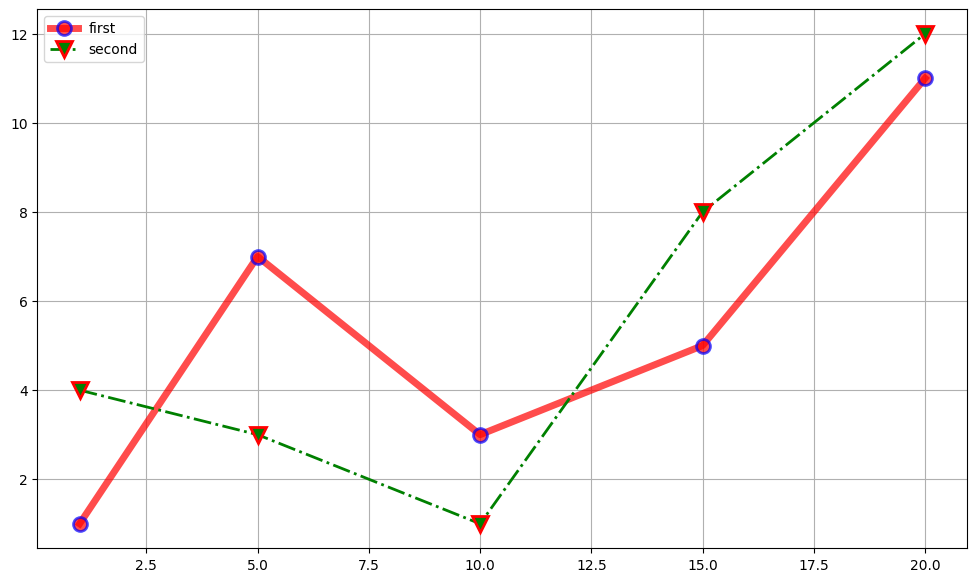

In [31]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [32]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torchmetrics.text import WordErrorRate
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import copy
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sacrebleu import corpus_bleu
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing

os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [33]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [34]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = ["_".join(path.parts[-3:-2][0].split("_")[:level]) for path in img_paths]
    if level != 1:
        model_name = "_".join(target[0].split("_")[:level-1])
    else:
        model_name = "full_model"
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(categories : list[str],
                       data_dir : Path,
                       SEED : int,
                       feedbacks : bool = False,
                       ):
    
    full_train_paths, full_test_paths = [], []
    for cat in categories:
        img_paths, target_enc, _, _ = get_target(data_dir,
                                                 feedbacks=False,
                                                 level=2,
                                                 category1=cat)

        train_paths, test_paths, _, _ = train_test_split(img_paths, target_enc,
                                                         test_size=0.2,
                                                         stratify=target_enc,
                                                         random_state=SEED)
        
        full_train_paths.extend(train_paths)
        full_test_paths.extend(test_paths)
        
    return full_train_paths, full_test_paths

In [35]:
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

In [36]:
def delete_none_items(paths: list[Path],
                      descriptions: pd.DataFrame,
                      embeddings: torch.Tensor):
    
    descriptions.reset_index(inplace=True)
    ind_isna = descriptions[descriptions["description"].isna()].index.tolist()
    ind_notna = descriptions[descriptions["description"].notna()].index.tolist()
    
    # удаление
    descriptions.drop(index=ind_isna, inplace=True)
    descriptions.reset_index(inplace=True)
    paths = list(pd.DataFrame(paths, columns=["paths"]).drop(index=ind_isna)["paths"])
    embeddings = torch.index_select(embeddings, dim=0, index=torch.from_numpy(np.array(ind_notna)))
    
    return paths, descriptions, embeddings


def text_prepocessing(text: str) -> str:
    text = text.lower()
    #text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions_and_embeds(paths: list[Path]):
    descriptions = []
    embeddings_check = False
    
    for path in paths:
#         print(path)
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
        embed = pd.read_csv(path.parents[1] / "embeddings.csv", index_col="item").loc[path.name]["embedding"].encode().decode('unicode-escape').encode('ISO-8859-1')[2:-1]
        embed = torch.from_numpy(np.copy(np.frombuffer(embed, dtype=np.float32))).view(1, -1)
        if embeddings_check:
            embeddings = torch.cat([embeddings, embed], dim=0)
        else:
            embeddings = torch.cat([embed], dim=0)
            embeddings_check = True
        
        
    df = pd.DataFrame(descriptions)
    paths, df, embeddings = delete_none_items(paths, df, embeddings)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df, embeddings, paths


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]", "[UNK]"])

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    # создаем шаблон, как надо выдавать предложения
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens=[
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]")),
        ],
    )
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [37]:
#tokenizer.token_to_id("[PAD]")
#tokenizer.encode("маша мыла раму. петя пишет AAA там тут и сям. +").ids

In [38]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data_embed_test"

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, target2idx, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=1,
                                                  category1="Обувь",
                                                  category2="Детская&электроника")
train_paths, test_paths = get_traintestsplit(categories=sorted(target2idx.keys()),
                                             data_dir=data_dir,
                                             SEED=SEED)
print(len(train_paths), len(test_paths))

335 84


In [39]:
descriptions_train, embeddings_train, train_paths = get_descriptions_and_embeds(train_paths)
descriptions_test, embeddings_test, test_paths = get_descriptions_and_embeds(test_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

print(len(train_paths), len(test_paths))
descriptions_train

11174
333 84


,level_0,index,description,descriptions_preproc
0,0,1.png,Уважаемые покупатели! В фотографиях представле...,уважаемые покупатели! в фотографиях представле...
1,1,3.png,Классические туфли и лоферы – эти модели должн...,классические туфли и лоферы – эти модели должн...
2,2,15.png,Ботинки челси для девочки подростка на небольн...,ботинки челси для девочки подростка на небольн...
3,3,2.png,Классические демисезонные кроссовки – это попу...,классические демисезонные кроссовки – это попу...
4,4,17.png,"Маломерят, внимательно выбирайте размер!\nНаша...","маломерят, внимательно выбирайте размер! наша ..."
...,...,...,...,...
328,330,0.png,Женские короткие резиновые сапоги выполнены в...,женские короткие резиновые сапоги выполнены в...
329,331,1.png,Открытые сандалии это комфортная обувь весной ...,открытые сандалии это комфортная обувь весной ...
330,332,2.png,Стильные женские балетки на прорезиненной подо...,стильные женские балетки на прорезиненной подо...
331,333,9.png,Не спешите писать негативный отзыв при следующ...,не спешите писать негативный отзыв при следующ...


In [40]:
#tokenizer.get_vocab()

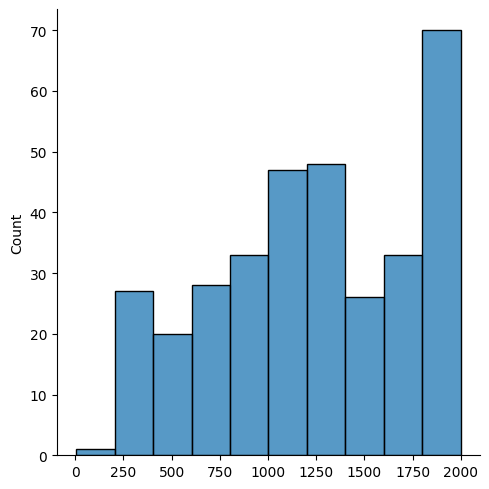

In [41]:
#Посмотрим на длину последоватеьностей
_ = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])

In [42]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 img_embeds: torch.Tensor,
                 descriptions: list[str],
                 tokenizer: Tokenizer,
                 max_length: int = 5000,
                ):

        self.img_paths = img_paths
        self.img_embeds = img_embeds
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]

        ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
        out = {"embed": self.img_embeds[index], "description": ids, "path": str(img_path)}
 
        return out


    def __len__(self):
        return len(self.img_embeds)

In [43]:
train_dataset = WbDataset(img_paths=train_paths,
                          img_embeds=embeddings_train,
                          descriptions=descriptions_train["descriptions_preproc"],
                          tokenizer=tokenizer,
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         img_embeds=embeddings_test,
                         descriptions=descriptions_test["descriptions_preproc"],
                         tokenizer=tokenizer,
                         )

In [44]:
item = train_dataset[0]

print(item.keys())
print(item["embed"].shape)
print(len(item["description"]))
print(len(tokenizer.decode(item["description"]).split()))

dict_keys(['embed', 'description', 'path'])
torch.Size([1024])
234
232


In [45]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["embed"])
        
        # Pad values
        out = {
            "embed": data,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
            "path": tensor_dict["path"],
        }

        return out

In [46]:
# train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(8)])
# test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(8)])
BATCH_SIZE = 4 #16

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [47]:
elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

In [48]:
elem["embed"].shape

torch.Size([4, 1024])

In [49]:
elem['description'].shape

torch.Size([4, 315])

In [50]:
elem['description'][0]

tensor([    1,  1811,  4415,    70,  1248,  2536,   126,   871,  1662,    30,
         2172,   414,  3441,    14,  3005,  4512,   126,   281,   121,   524,
         7211,  6825,    15,  2057,  9229,    70,  4012,  5219,  1538,  2095,
         3110,   871,  2290,    64,  2853,    15,  3441,    14,  3005,   126,
          281,    95,   233,  8333,  2550,   126, 10451,   281,    70,  2163,
           15,  1248,   725,    70,  1502,  1274,   968,  1142,  1002,  1011,
          126,  1596,  1813,    15,  1358,   121,  1084,    13,  8770,   218,
         8696,    13,  2057,  3441,    14,  3005,   661,  3993,    15,  1288,
         3441,    14,  3005,   126,   281,  1192,   486,  6837,  7876,    13,
          826,  1191,  1663,   925,   915,  1142,   104,  9093,    15,  3802,
         2152,    70,  9830,    13,   612,   123,   887,  3588,  6511, 10409,
          126,   871,  1662,    15,   123,  1689,  1228,  9279,  4562,  1722,
         1663,    70,  2898,  1142,  2868,  6268,  1570,  6198, 

___

Доделать по датасету:
 - добавить decode encode

Нерешенные вопросы:
 - подумать какой лучше брать токенайзер
 - как делать предикт:
   - categorical или argmax
   - критерии останова
   - как прогонять сразу батчом

In [51]:
class DecoderRNN(nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        image_embed_dim,
        embed_dim : int = 256,
        hidden_dim : int = 256,
        lstm_layers : int = 1,
        dropout_prob: float = 0.1,
    ):
        super().__init__()
        
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        self.tokenizer = tokenizer
        
        self.image_embed_to_h0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = torch.nn.Sequential(
            torch.nn.Linear(in_features=image_embed_dim, out_features=lstm_layers * hidden_dim),
            torch.nn.LeakyReLU(0.1),
        )
        
        self.embed = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        self.lstm = torch.nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True, 
        )
        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_dim, out_features=tokenizer.get_vocab_size()),
        )

    def forward(self, image_embeds, captions):
        batch_size = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(batch_size, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        
        embeds = self.embed(captions)
        lengths = (captions != 0).sum(dim=-1).cpu()
        
#         print(h0.shape)
#         print(embeds.shape)
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self.lstm(packed, (h0, c0))
        output, lens_unpacked = pad_packed_sequence(lstm_out, batch_first=True)
#         print(output.shape)
        logits = self.linear(output)
#         print(logits.shape)

        return logits
    
    
    @torch.no_grad()
    def caption_image(
        self,
        image_embeds : torch.Tensor,
        max_length : int = 300,
        greedy : bool = False,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)

        # init tokens with <bos>
        tokens = torch.full((batch_size, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        new_tokens = tokens
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < max_length:
            if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
                break  

            embeds = self.embed(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
#             print(output.shape)
            logits = self.linear(output)

            if greedy:
                new_tokens = logits.argmax(dim=-1)
            else:
                new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

        return tokens


#     @torch.no_grad()
#     def caption_image_beam_search(
#         self,
#         image_embeds : torch.Tensor,
#         beam_size : int,
#         max_length : int = 300,
#     ):
#         self.eval()

#         batch_size = image_embeds.shape[0]
#         if batch_size > 1:
#             raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
#         h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
#                                                          self.lstm_layers,
#                                                          self.hidden_dim).transpose(0, 1)
#         c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
#                                                          self.lstm_layers,
#                                                          self.hidden_dim).transpose(0, 1)

#         k = beam_size
#         # init tokens with <bos>
#         # tokens = seqs, new_token = k_prev_word
#         k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
#         seqs = k_prev_words
        
#         top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
#         complete_seqs = list()
#         complete_seqs_scores = list()
        
#         h, c = h.expand(-1, k, self.hidden_dim), c.expand(-1, k, self.hidden_dim)
#         h, c = h.contiguous(), c.contiguous()
        
#         # 2 stopping conditions: reaching max len or getting <eos> token
#         step = 1        
#         while True:
# #             if ((tokens == self.tokenizer.get_vocab()["[EOS]"]).sum(1) > 0).all():   # тут надо проверить
# #                 break  

#             embeds = self.embed(k_prev_words)
#             output, (h, c) = self.lstm(embeds, (h, c))
# #             print(output.shape)
#             logits = self.linear(output)
#             print(logits.shape)
#             scores = F.log_softmax(logits[:, -1:, :], dim=-1)
#             print(scores.shape)
#             scores = scores.reshape(k, self.tokenizer.get_vocab_size())
            
#             print(top_k_scores.shape, scores.shape, h.shape)
#             scores = top_k_scores.expand_as(scores) + scores
            
#             if step == 1:
#                 top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
#             else:
#                 top_k_scores, top_k_words = scores.topk(k, -1, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
            
#             print(seqs.shape)
#             print(seqs)
#             seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
#             print(seqs)
            
#             incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
#                                next_word != self.tokenizer.get_vocab()["[EOS]"]]
#             complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

#             print(complete_inds, incomplete_inds)
#             k -= len(complete_inds)
#             if k == 0:
#                 break
            
#             seqs = seqs[incomplete_inds]
#             h = h[0][incomplete_inds].reshape(-1, k, self.hidden_dim)
#             c = c[0][incomplete_inds].reshape(-1, k, self.hidden_dim)
#             top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
#             k_prev_words = torch.cat([k_prev_words[incomplete_inds], top_k_words[incomplete_inds].unsqueeze(1)], dim=-1)
#             print(k_prev_words)
#             print("----------------------------------------------------------------")
# #             return

# #             new_tokens = Categorical(logits=logits).sample()      #logits.argmax(dim=-1)
# #             tokens = torch.cat([tokens, new_tokens], dim=1)                              # концовка будет другая

#             if step > max_length:
#                 break
#             step += 1

#         return

    @torch.no_grad()
    def caption_image_beam_search(
        self,
        image_embeds : torch.Tensor,
        beam_size : int,
        max_length : int = 300,
    ):
        self.eval()

        batch_size = image_embeds.shape[0]
        if batch_size > 1:
            raise ValueError(f'Expected input batch_size (1) but got ({batch_size})')
        
        h = self.image_embed_to_h0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(batch_size,
                                                         self.lstm_layers,
                                                         self.hidden_dim).transpose(0, 1)

        k = beam_size
        # init tokens with <bos>
        # tokens = seqs, new_token = k_prev_word
        k_prev_words = torch.full((k, 1), self.tokenizer.get_vocab()["[BOS]"], device=image_embeds.device)
        seqs = k_prev_words
        
        top_k_scores = torch.zeros(k, 1, device=image_embeds.device)
        
        complete_seqs = list()
        complete_seqs_scores = list()
        uncomplete_seqs = list()
        uncomplete_seqs_scores = list()
        
        h, c = h.expand(self.lstm_layers, k, self.hidden_dim), c.expand(self.lstm_layers, k, self.hidden_dim)
        h, c = h.contiguous(), c.contiguous()
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        step = 1        
        while True:
            embeds = self.embed(k_prev_words)
            output, (h, c) = self.lstm(embeds, (h, c))
#             print(output.shape)
            logits = self.linear(output)
#             print(logits.shape)
            scores = F.log_softmax(logits[:, -1:, :], dim=-1)
            print(scores.shape)
            scores = scores.reshape(k, self.tokenizer.get_vocab_size())
            
#             print(top_k_scores.shape, scores.shape, h.shape)
            scores = top_k_scores.expand_as(scores) + scores
            
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
#                 print(top_k_scores.shape, top_k_words.shape)
#                 print(top_k_scores, top_k_words)
                seqs = torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)
            else:
                # выбираем 9 наилучших (по 3 для каждого предсказания)
                top_kk_scores, top_kk_words = scores.topk(k, -1, True, True)
#                 print(top_kk_scores.shape, top_kk_words.shape)
#                 print(top_kk_scores, top_kk_words)
                
                # выбираем из 9 наилучших 3 наилучшие
                top_k_scores, top_k_idx_flat = top_kk_scores.view(-1).topk(k, 0, True, True)
                top_k_idx_col = top_k_idx_flat // k
                top_k_idx_row = top_k_idx_flat % k
                top_k_idx = torch.cat([top_k_idx_col.unsqueeze(1), top_k_idx_row.unsqueeze(1)], dim=-1) 
#                 for i in range(top_k_scores.shape[0]):
#                     if i == 0:
#                         top_k_idx = torch.cat([(top_kk_scores == top_k_scores[i]).nonzero()])
#                     else:
#                         top_k_idx = torch.cat([top_k_idx, (top_kk_scores == top_k_scores[i]).nonzero()])
                
                # переформировываем соответствующе 3м наилучшим seqs 
                for i in range(top_k_idx.shape[0]):
                    num_str = top_k_idx[i][0]
                    top_k_word = top_kk_words[num_str][top_k_idx[i][1]].unsqueeze(0) 
                    seq = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
                    if i == 0:        
                        seqs_new = torch.cat([seq], dim=0)
                        h_new = torch.cat([h[:, [num_str], :]], dim=1)
                        c_new = torch.cat([c[:, [num_str], :]], dim=1)
                        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_word], dim=0)
                    else:
                        seqs_new = torch.cat([seqs_new, seq], dim=0)
                        
                        h_new = torch.cat([h_new, h[:, [num_str], :]], dim=1)
                        c_new = torch.cat([c_new, c[:, [num_str], :]], dim=1)
                        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
                        top_k_words = torch.cat([top_k_words, top_k_word], dim=0)
                seqs = copy.deepcopy(seqs_new)
                h = copy.deepcopy(h_new)
                c = copy.deepcopy(c_new)
            
#             print(seqs.shape)
#             print(seqs)
            
            incomplete_inds = [ind for ind, next_word in enumerate(top_k_words) if
                               next_word != self.tokenizer.get_vocab()["[EOS]"]]
            complete_inds = list(set(range(len(top_k_words))) - set(incomplete_inds))

#             print(complete_inds, incomplete_inds)
            if len(complete_inds) > 0:
                complete_seqs.append(seqs[complete_inds])
                complete_seqs_scores.append(top_k_scores[complete_inds])
                
            k -= len(complete_inds)            
            if k == 0:
                break
            
            seqs = seqs[incomplete_inds]
            h = h[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            c = c[:, incomplete_inds, :].reshape(self.lstm_layers, k, self.hidden_dim)
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = seqs[:, -1:]                                  # seqs[:, -k:] сколько последних слов подавать в модель
#             print(k_prev_words)
#             print("----------------------------------------------------------------")

            if step > max_length:
#                 print(seqs)
#                 print(incomplete_inds)
#                 print(top_k_scores)
                uncomplete_seqs.append(seqs[incomplete_inds])
                uncomplete_seqs_scores.append(top_k_scores[incomplete_inds])
                break
            step += 1

        return complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores

# прыг тестирование кода

In [28]:
for batch in test_loader:
    break

In [29]:
complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                      image_embeds=batch['embed'],
                                                                      beam_size=3,
                                                                      max_length=10)

torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])
torch.Size([3, 1, 11174])


In [41]:
# captions = model.caption_image(image_embeds=batch['embed'], max_length=100, greedy=True)
# captions

In [42]:
# complete_seqs, complete_seqs_scores

In [48]:
# uncomplete_seqs, uncomplete_seqs_scores

In [47]:
# print('ИСТИННОЕ ОПИСАНИЕ')
# print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()))
# print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
# print(tokenizer.decode(uncomplete_seqs[0][0].detach().cpu().numpy()))

In [26]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=2,
    hidden_dim=128,
)

# NUM_EPOCHS = 500

# model = model.to(device)
# optimizer = torch.optim.AdamW(
#     [
#         {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
#     ],
# )
# criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
# model, optimizer = accelerator.prepare(model, optimizer)

#accelerator.load_state(Path.cwd() / "rnn_test")
model.load_state_dict(torch.load(Path.cwd() / "rnn_test" / "pytorch_model.bin"))
model = model.to(device)

In [27]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [24]:
#accelerator.save_state(output_dir=Path.cwd() / "rnn_test2")

WindowsPath('C:/Users/sofi/jupyter projects/МОВС/HSE_MLDS_project_year2/rnn_test2')

In [56]:
top_k_scores = torch.Tensor([[-17.8405, -17.8495, -17.8506],
                             [-17.8405, -17.8405, -17.8893],
                             [-17.8216, -17.8496, -17.8640]])
top_k_words = torch.Tensor([[ 6530, 7469, 9851],
                            [ 9234, 2803, 10718],
                            [ 9364, 5415, 505]]).type(torch.int64)
seqs = torch.tensor([[    1, 10640],
                     [    1,  4231],
                     [    1,  6530]])
h = torch.arange(6).reshape((1,3,2))

In [57]:
scores, words = top_k_scores.view(-1).topk(3, 0, True, True)
scores, words

(tensor([-17.8216, -17.8405, -17.8405]), tensor([6, 0, 3]))

In [76]:
a1 = words // 3
a2 = words % 3

tensor([0, 0, 0])

In [84]:
torch.cat([a1.unsqueeze(1), a2.unsqueeze(1)], dim=-1)

tensor([[2, 0],
        [0, 0],
        [1, 0]])

In [60]:
for i in range(scores.shape[0]):
    if i == 0:
        idx = torch.cat([(top_k_scores == scores[i]).nonzero()])
    else:
        idx = torch.cat([idx, (top_k_scores == scores[i]).nonzero()])
        print(idx)

tensor([[2, 0],
        [0, 0],
        [1, 0],
        [1, 1]])
tensor([[2, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 1]])


In [61]:
idx

tensor([[2, 0],
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 0],
        [1, 0],
        [1, 1]])

In [42]:
top_k_words[2][0]

tensor(9364)

In [50]:
for i in range(len(idx)):
    num_str = idx[i][0]
    top_k_word = top_k_words[num_str][idx[i][1]].unsqueeze(0)                                
    a1 = torch.cat([seqs[num_str], top_k_word], dim=0).unsqueeze(0)
    if i == 0:        
        a2 = torch.cat([a1], dim=0)
        num_strs = torch.cat([num_str.unsqueeze(0)], dim=0)
        top_k_words2 = torch.cat([top_k_word], dim=0)
        h2 = torch.cat([h[:, num_str]], dim=0)
    else:
        a2 = torch.cat([a2, a1], dim=0)
        num_strs = torch.cat([num_strs, num_str.unsqueeze(0)], dim=0)
        top_k_words2 = torch.cat([top_k_words2, top_k_word], dim=0)
        h2 = torch.cat([h2, h[:, num_str]], dim=0)

In [51]:
a2, num_strs, top_k_words2, h2

(tensor([[    1,  6530,  9364],
         [    1, 10640,  6530],
         [    1, 10640,  7469]]),
 tensor([2, 0, 0]),
 tensor([9364, 6530, 7469]),
 tensor([[4, 5],
         [0, 1],
         [0, 1]]))

In [53]:
h2.unsqueeze(0).shape

torch.Size([1, 3, 2])

In [113]:
top_k_words[idx[0][0][0]][idx[0][0][1]]

tensor(9364.)

In [118]:
seqs.dtype

torch.int64

In [128]:
top_k_words

tensor([[ 6530,  7469,  9851],
        [ 9234,  2803, 10718],
        [ 9364,  5415,   505]])

In [90]:
top_k_words[idx[0][0][0]][idx[0][0][1]]

tensor(9364.)

In [ ]:
[[    1, 10640, 6530],
 [    1, 10640, 7469],
 [    1, 6530, 9364]]

In [85]:
a1 = [1,2,3]
a1.extend([5,6,7])

In [86]:
a1

[1, 2, 3, 5, 6, 7]

In [69]:
torch.cat([seqs, top_k_words.unsqueeze(1)], dim=-1)

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [30]:
a1 = torch.arange(12).reshape((2,3,2))
print(a1.shape)
a1[:, [0], :]

torch.Size([2, 3, 2])


tensor([[[0, 1]],

        [[6, 7]]])

In [32]:
torch.cat([a1[:, [0], :]], dim=1)

tensor([[[0, 1]],

        [[6, 7]]])

In [84]:
a1

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])

In [36]:
torch.Tensor([[[1,2]]]).shape

torch.Size([1, 1, 2])

In [120]:
log_softmax(torch.Tensor([[2, 3, -5], [-1, 0, 1.04]]), dim=-1)

tensor([[-1.3135, -0.3135, -8.3135],
        [-2.4344, -1.4344, -0.3944]])

In [156]:
softmax(test, dim=2)

tensor([[[0.2689, 0.7311]],

        [[0.2689, 0.7311]],

        [[0.2689, 0.7311]]])

In [45]:
a1 = torch.Tensor([10, 10, 10]).reshape((3,1))
test = torch.arange(9, dtype=torch.float).reshape((3,3))
test.shape, a1.shape

(torch.Size([3, 3]), torch.Size([3, 1]))

In [47]:
a2 = a1.expand_as(test) + test
a2

tensor([[10., 11., 12.],
        [13., 14., 15.],
        [16., 17., 18.]])

In [49]:
top_k_scores, top_k_words = a2.topk(2, dim=-1, largest=True, sorted=True)
top_k_scores, top_k_words

(tensor([[12., 11.],
         [15., 14.],
         [18., 17.]]),
 tensor([[2, 1],
         [2, 1],
         [2, 1]]))

In [40]:
top_k_words 

tensor([2.6667, 2.3333])

In [219]:
torch.Tensor([2559, 9233, 2349]).unsqueeze(1)

tensor([[2559.],
        [9233.],
        [2349.]])

In [ ]:
scores.view(-1).topk(k, 0, True, True)

In [189]:
beam_size = 2
k = beam_size
s = k

k_prev_words = torch.LongTensor([[10]] * k)
seqs = k_prev_words
top_k_scores = torch.zeros(k, 1)
top_k_scores

tensor([[0.],
        [0.]])

In [190]:
seqs

tensor([[10],
        [10]])

In [191]:
vocab_size = 3
scores = torch.Tensor([[0.6, 0.1, 0.3], [0.6, 0.1, 0.3]])
scores

tensor([[0.6000, 0.1000, 0.3000],
        [0.6000, 0.1000, 0.3000]])

In [192]:
scores = top_k_scores.expand_as(scores) + scores
scores

tensor([[0.6000, 0.1000, 0.3000],
        [0.6000, 0.1000, 0.3000]])

In [193]:
top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
top_k_scores, top_k_words

(tensor([0.6000, 0.3000]), tensor([0, 2]))

In [194]:
prev_word_inds = top_k_words / vocab_size  # (s)
next_word_inds = top_k_words % vocab_size
prev_word_inds, next_word_inds

(tensor([0.0000, 0.6667]), tensor([0, 2]))

In [195]:
seqs = torch.cat([seqs[[0,1]], next_word_inds.unsqueeze(1)], dim=1)
seqs

tensor([[10,  0],
        [10,  2]])

In [196]:
incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != 34]
complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
incomplete_inds, complete_inds

([0, 1], [])

In [197]:
seqs = seqs[incomplete_inds]
seqs

tensor([[10,  0],
        [10,  2]])

In [198]:
top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)
top_k_scores, k_prev_words

(tensor([[0.6000],
         [0.3000]]),
 tensor([[0],
         [2]]))

In [199]:
scores = torch.Tensor([[0.5, 0.15, 0.35], [0.2, 0.7, 0.1]])

In [200]:
scores = top_k_scores.reshape((2,1)).expand_as(scores) + scores
scores

tensor([[1.1000, 0.7500, 0.9500],
        [0.5000, 1.0000, 0.4000]])

In [201]:
top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)
top_k_scores, top_k_words

(tensor([1.1000, 1.0000]), tensor([0, 4]))

In [202]:
scores.view(-1)

tensor([1.1000, 0.7500, 0.9500, 0.5000, 1.0000, 0.4000])

In [203]:
prev_word_inds = top_k_words / vocab_size  # (s)
next_word_inds = top_k_words % vocab_size
prev_word_inds, next_word_inds

(tensor([0.0000, 1.3333]), tensor([0, 1]))

In [204]:
seqs = torch.cat([seqs[[0,1]], next_word_inds.unsqueeze(1)], dim=1)
seqs

tensor([[10,  0,  0],
        [10,  2,  1]])

In [558]:
beam_index = 2
start_word = [[[10], 0.0]]
start_word

[[[10], 0.0]]

In [559]:
for s in start_word:
    print(s)

[[10], 0.0]


In [560]:
temp = []

In [561]:
preds = torch.Tensor([[0.5, 0.15, 0.35]])

In [562]:
word_preds = np.argsort(preds[0])[-beam_index:]
word_preds

tensor([2, 0])

In [563]:
for w in word_preds:
    next_cap, prob = start_word[0][0][:], start_word[0][1]
    next_cap.append(int(w))
    print(next_cap)
    print(preds[0][w])
    prob += preds[0][w]
    temp.append([next_cap, prob])

[10, 2]
tensor(0.3500)
[10, 0]
tensor(0.5000)


In [564]:
temp

[[[10, 2], tensor(0.3500)], [[10, 0], tensor(0.5000)]]

In [565]:
start_word = temp

In [566]:
start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
# Getting the top words
start_word = start_word[-beam_index:]

In [567]:
start_word

[[[10, 2], tensor(0.3500)], [[10, 0], tensor(0.5000)]]

In [568]:
temp = []
pred = torch.Tensor([[0.2,0.55,0.25], [0.3,0.3,0.4]])

In [569]:
i = 0
for s in start_word:
    preds = pred[i]
    i +=1
            
    # Getting the top <beam_index>(n) predictions
    word_preds = np.argsort(preds)[-beam_index:]
    print(word_preds)
    # creating a new list so as to put them via the model again
    for w in word_preds:
            next_cap, prob = s[0][:], s[1]
            next_cap.append(int(w))
            prob += preds[w]
            temp.append([next_cap, prob])

tensor([2, 1])
tensor([1, 2])


In [570]:
temp

[[[10, 2, 2], tensor(1.1500)],
 [[10, 2, 1], tensor(1.1500)],
 [[10, 0, 1], tensor(1.2000)],
 [[10, 0, 2], tensor(1.2000)]]

In [571]:
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

In [572]:
start_word

[[[10, 0, 1], tensor(1.2000)], [[10, 0, 2], tensor(1.2000)]]

In [573]:
start_word[-1][0]

[10, 0, 2]

In [574]:
for s in start_word:
    print(s[0])

[10, 0, 1]
[10, 0, 2]


# прыг запуск training

In [23]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

    
def calculate_bleu_wer(model, image_embeds, captions_true):
    bleu_scores = []
    wer_scores = []
    wer = WordErrorRate()
    
    for i in range(image_embeds.shape[0]):
        caption_pred = model.caption_image(image_embeds=image_embeds[i].view(1, -1))

        caption_true = model.tokenizer.decode(captions_true[i].detach().cpu().numpy())
        caption_pred = model.tokenizer.decode(caption_pred[0].detach().cpu().numpy())
    
        bleu_score = corpus_bleu(caption_pred, [caption_true]).score
        bleu_scores.append(bleu_score)
        
        wer_score = wer(caption_pred, caption_true)
        wer_scores.append(wer_score)
    
    bleu = np.mean(bleu_scores)
    wer = np.mean(wer_scores)
    
    return {"BLEU": bleu, "WER": wer}

In [24]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        train_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            with self.accelerator.accumulate(self.model):
                logits_captioning = self.model(img_embed, descriptions[:, :-1])
                loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m
    
            num_batches += 1

        train_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in train_metrics:
                metrics[m_name] = train_metrics[m_name][-1]
            
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
        val_metrics,
        metric_epoch : int,
        metrics_freq: int,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
            img_embed = batch["embed"]
            descriptions = batch["description"]
            
            logits_captioning = self.model(img_embed, descriptions[:, :-1])
            loss = self.criterion(logits_captioning.transpose(1, 2), descriptions[:, 1:])

            val_loss += loss.item()
            
            if (metric_epoch) % metrics_freq == 0:
                metrics_captioning = calculate_bleu_wer(model, batch['embed'], batch['description'])
                for m_name, m in metrics_captioning.items():
                    metrics[m_name] += m

            num_batches += 1

        val_loss /= num_batches
        if (metric_epoch) % metrics_freq == 0:
            for m_name in metrics:
                metrics[m_name] /= num_batches
        else:
            for m_name in val_metrics:
                metrics[m_name] = val_metrics[m_name][-1]

            
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        calculate_metrics: bool = True,
        metrics_freq: int = 10,
        saving_checkpoint: bool = False,
        save_path_checkpoint: Optional[Path] = None,
        saving_model: bool = False,
        save_path_model: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}',
                train_metrics=train_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch, 
                metrics_freq=metrics_freq,
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}',
                val_metrics=val_metrics,
                metric_epoch=epoch-1 if calculate_metrics else epoch,
                metrics_freq=metrics_freq,
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value)
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value)
            
            if plot:
                plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving_checkpoint:
                accelerator.save_state(output_dir=save_path_checkpoint / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        if saving_model:
            shutil.rmtree(save_path_model, ignore_errors=True)
            accelerator.save_state(output_dir=save_path_model)

        return train_losses, val_losses, train_metrics, val_metrics

In [25]:
model = DecoderRNN(
    tokenizer=tokenizer,
    image_embed_dim=embeddings_train.shape[1],
    lstm_layers=2,
    hidden_dim=128,
)

sum(param.numel() for param in model.parameters())

5156518

In [26]:
NUM_EPOCHS = 100

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
    ],
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.get_vocab()["[PAD]"]).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [27]:
# NUM_EPOCHS = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


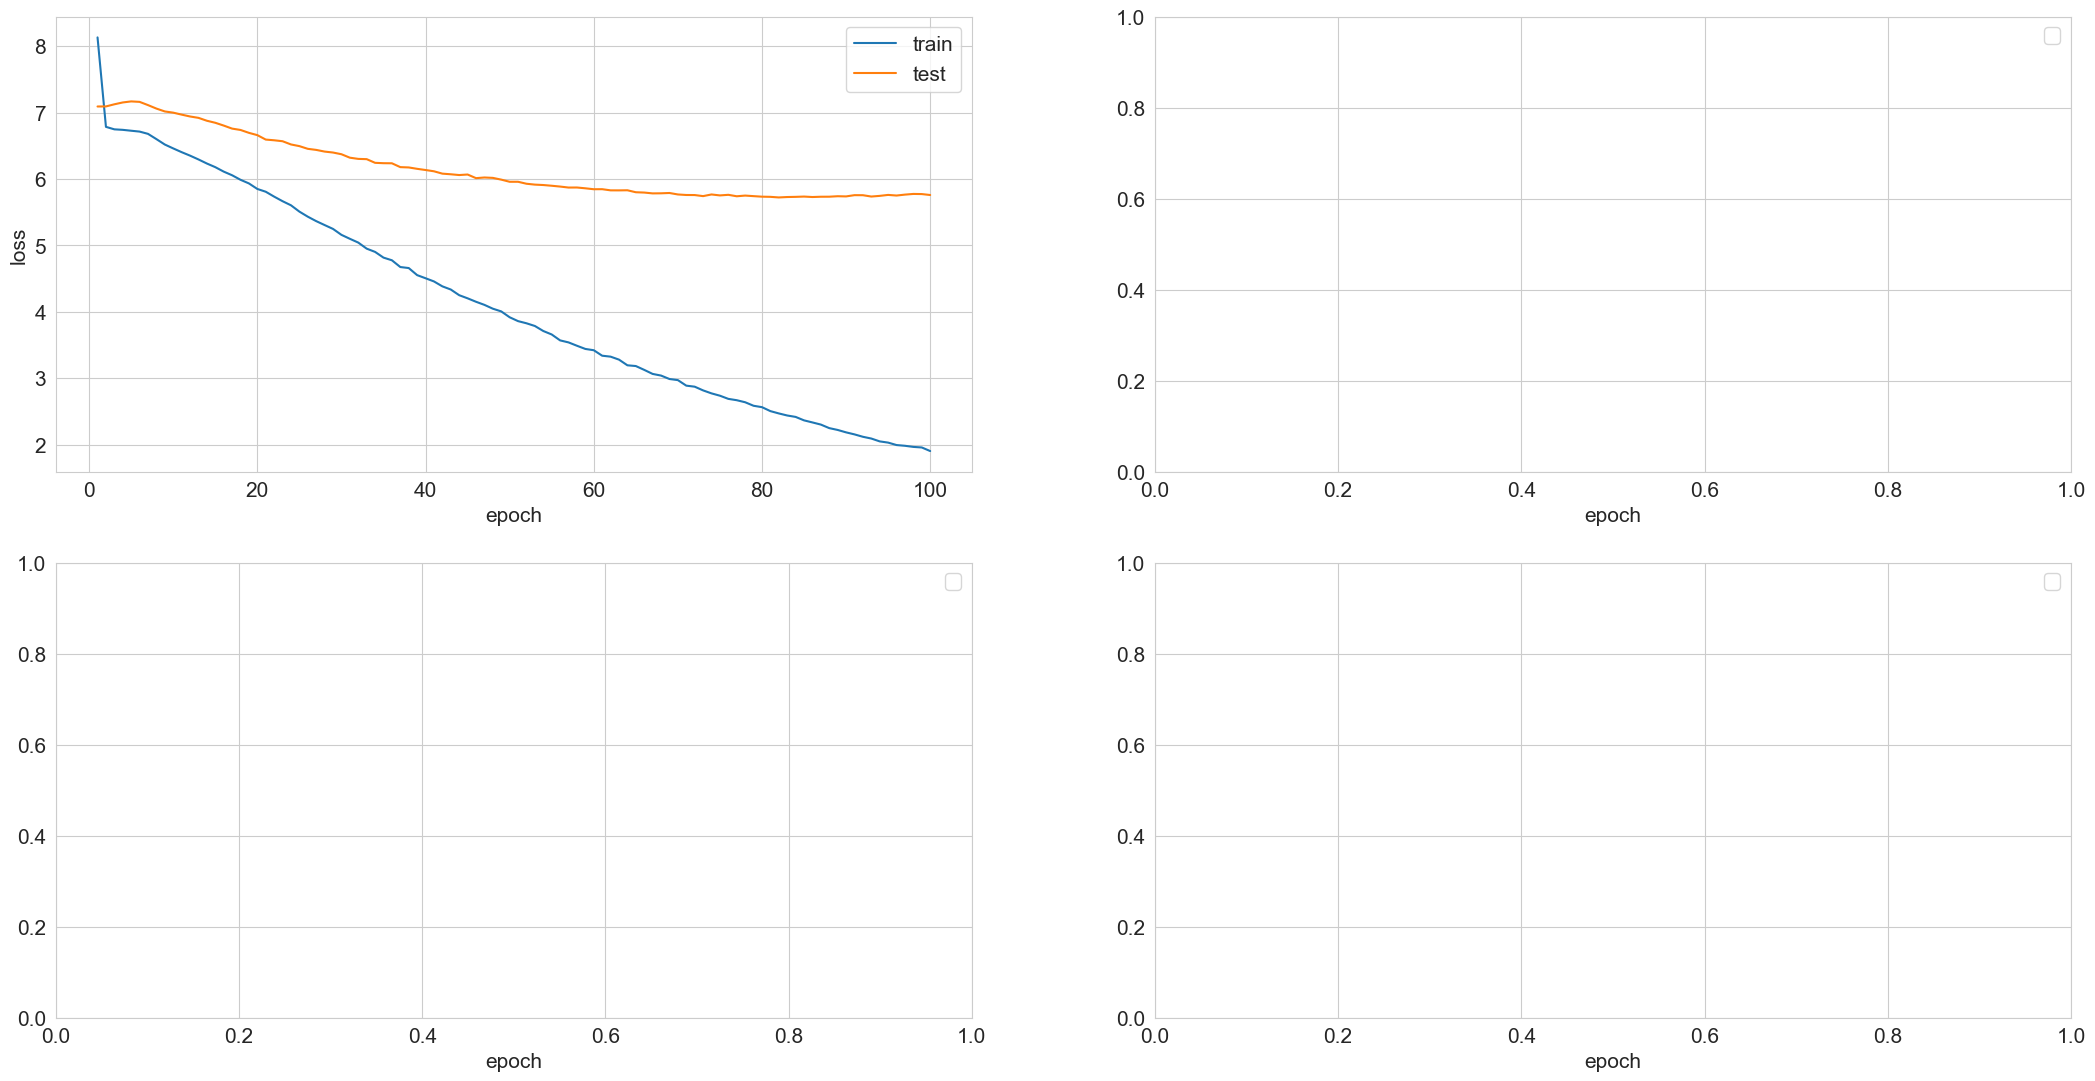

Epoch 100
val metrics
loss 5.758609056472778

train metrics
loss 1.9019520424661183
--------------------------------------------------
0:11:58.555032


In [28]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test2")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


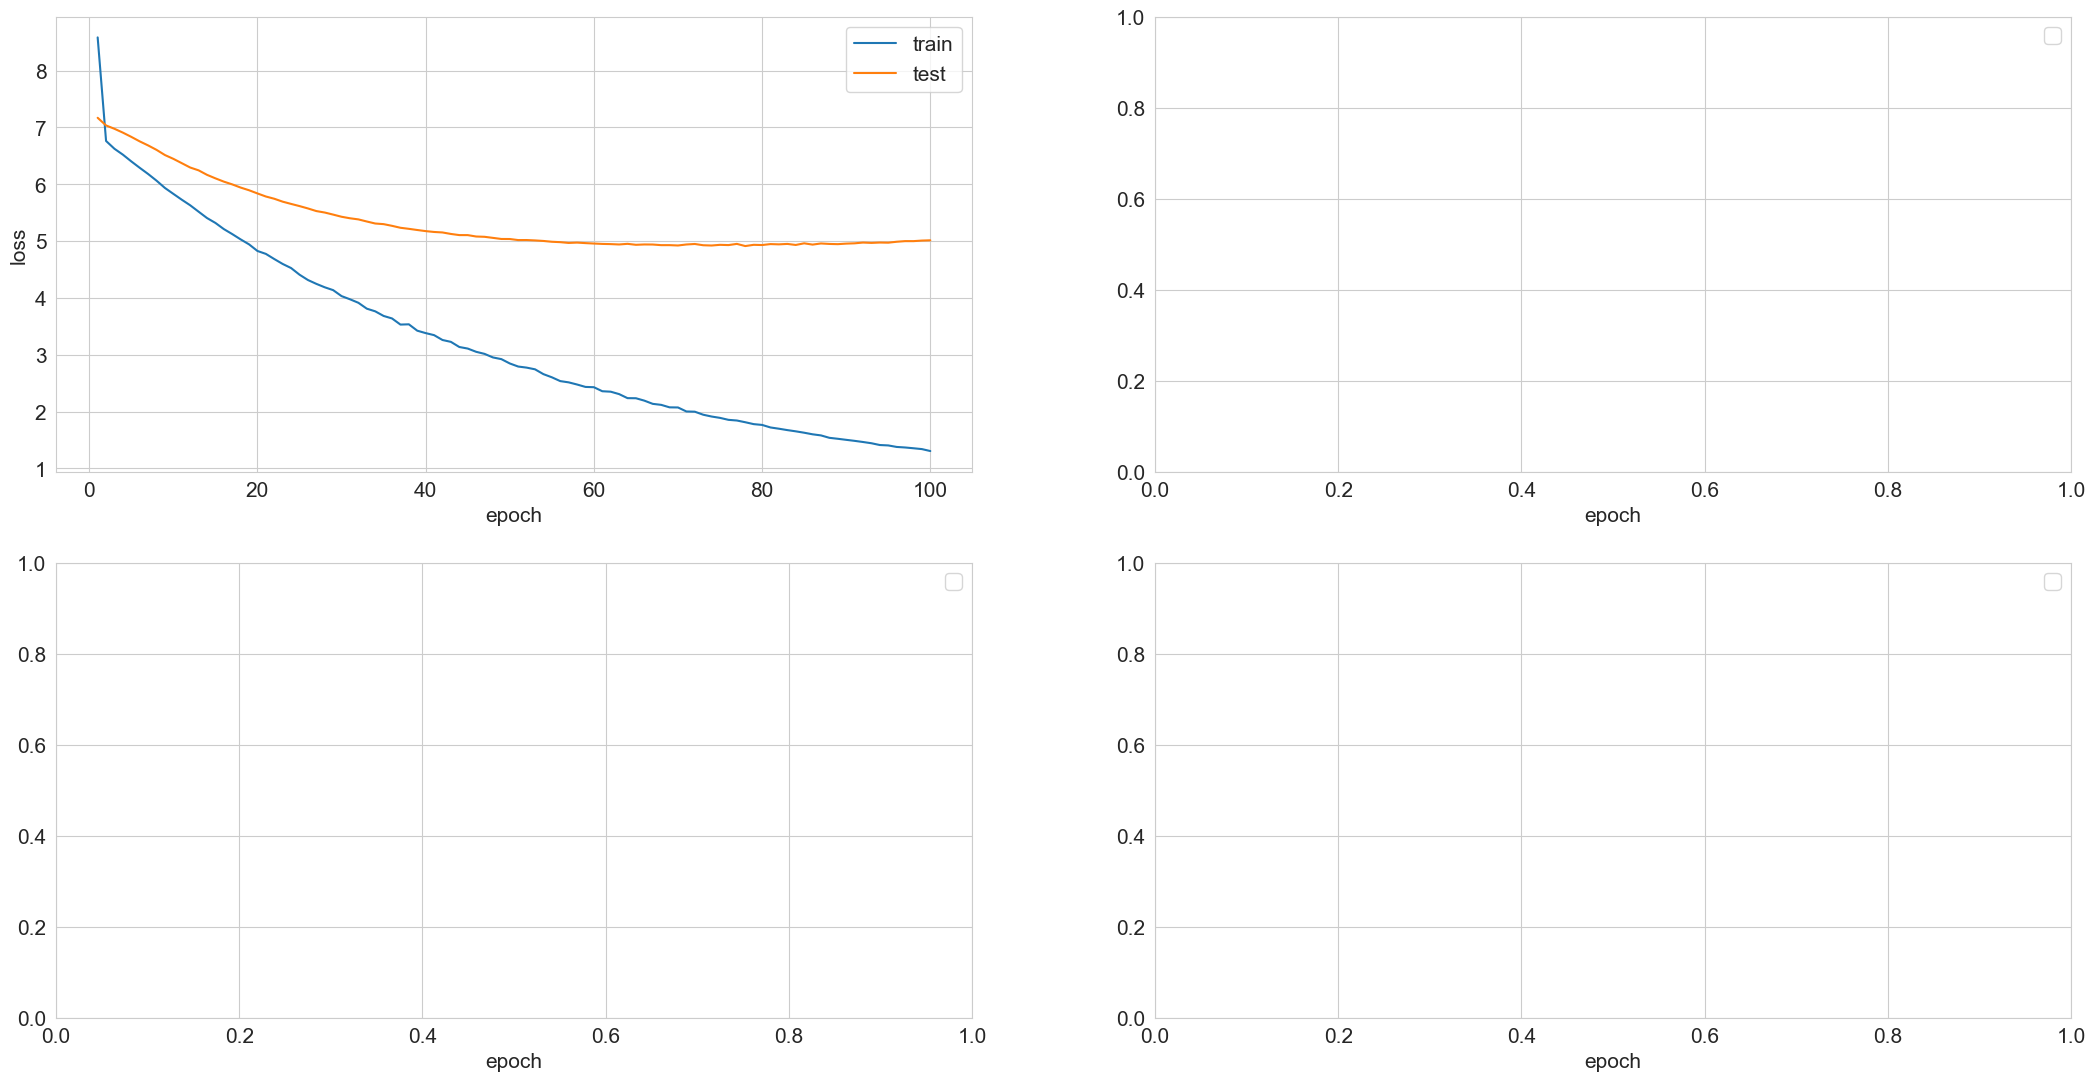

Epoch 100
val metrics
loss 5.013119260470073

train metrics
loss 1.3048269975753057
--------------------------------------------------
0:10:42.015122


In [28]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000,
            saving_model=True, save_path_model=Path.cwd() / "rnn_test")
b = datetime.now()
print(b - a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


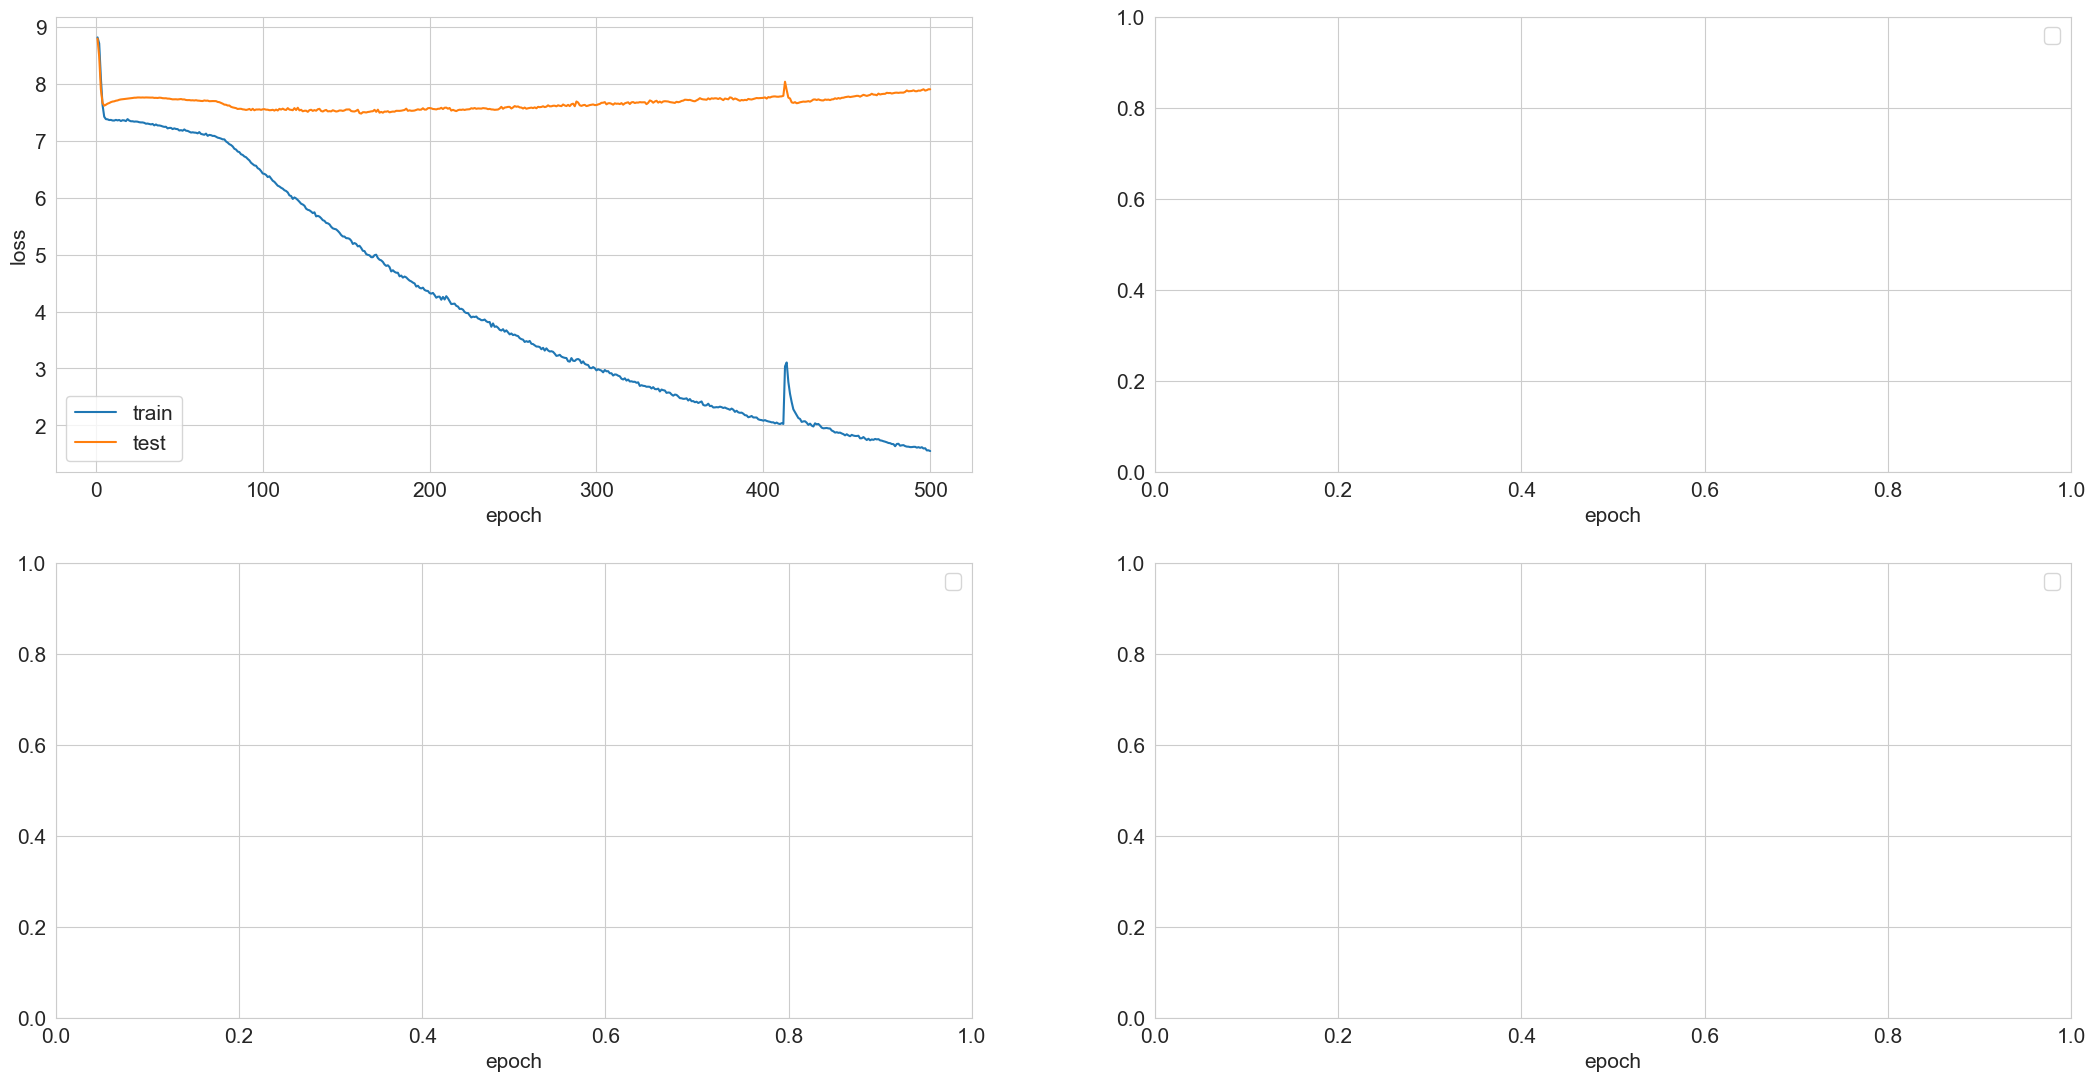

Epoch 500
val metrics
loss 7.907747507095337

train metrics
loss 1.5483036935329437
--------------------------------------------------
0:29:32.046039


In [31]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, plot=True, calculate_metrics=False, metrics_freq=1000)
b = datetime.now()
print(b - a)

In [79]:
one = torch.ones(2, 3, 2)
zero = torch.zeros(2, 3, 2)
three = torch.reshape(torch.arange(1,13), (2, 3, 2))

a1 = torch.cat([one,zero], dim=-1)
torch.cat([a1, three], dim=-1)

tensor([[[ 1.,  1.,  0.,  0.,  1.,  2.],
         [ 1.,  1.,  0.,  0.,  3.,  4.],
         [ 1.,  1.,  0.,  0.,  5.,  6.]],

        [[ 1.,  1.,  0.,  0.,  7.,  8.],
         [ 1.,  1.,  0.,  0.,  9., 10.],
         [ 1.,  1.,  0.,  0., 11., 12.]]])

In [76]:
torch.reshape(torch.arange(1,13), (2, 3, 2))

tensor([[[ 1,  2],
         [ 3,  4],
         [ 5,  6]],

        [[ 7,  8],
         [ 9, 10],
         [11, 12]]])

# Prediction  

In [29]:
test_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [36]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

  0%|          | 0/240 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.6526946}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 0.9010989}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.8939394}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.825}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9306569}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

{'BLEU': 0.0, 'WER': 0.9459459}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.89506173}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9447236}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.5393258}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.95731705}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])

{'BLEU': 0.0, 'WER': 0.9259259}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

{'BLEU': 0.0, 'WER': 0.9326923}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.92899406}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.8901099}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9319728}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.2075472}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9320755}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 1.5588236}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.8974359}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.4831461}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9086022}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9222222}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.0333333}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.7058823}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9315069}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.93133044}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 3.8939395}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.96511626}
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9027027}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

KeyboardInterrupt: 

In [34]:
a = datetime.now()
for batch in tqdm(test_loader):
    #break
    metrics = calculate_bleu_wer(model.cpu(), batch['embed'].cpu(), batch['description'].cpu())
    print(metrics)
b = datetime.now()
print(b - a)
print()

# a = datetime.now()
# for batch in tqdm(test_loader):
#     metrics = calculate_bleu_wer(model.to(device), batch['embed'].to(device), batch['description'].to(device))
#     print(metrics)
# b = datetime.now()
# print(b - a)

  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.97959185}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9488636}
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.4344262}
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.938326}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Siz

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.9551282}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 0.98245615}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.S

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
{'BLEU': 0.0, 'WER': 1.5980393}
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Si

In [46]:
for batch in tqdm(test_loader):
    break

metrics = calculate_bleu_wer(model, batch['embed'], batch['description'])
metrics

  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 1

{'BLEU': 0.0, 'WER': 0.9712794}

In [30]:
def visualise_predict(loader: DataLoader,
                      model,
                      tokenizer : Tokenizer,
                      max_length : int = 300,
                      greedy : bool = False) -> None:
    for batch in loader:
        captions = model.caption_image(image_embeds=batch['embed'], max_length=max_length, greedy=greedy)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(captions[0].detach().cpu().numpy()))
        
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [31]:
preds = visualise_predict(test_loader, model, tokenizer)

ИСТИННОЕ ОПИСАНИЕ
оригинальные и стильные туфли — это универсальная и комфортная обувь . модные туфли на среднем каблуке бренда t . taccardi эффектно дополнят любой ваш образ . современные босоножки женские станут отличным дополнением к любому вашему образу . туфли летние подойдут также на теплую осень и весну . обувь на каблуке идеально вписываются в ваш образ на вечеринку , день рождения и новый год . а невеста удачно может сочетать туфли с платьем на свадьбе или предложить подружкам невесты подобрать данную модель к вечернему образу . удобная колодка и устойчивый каблук средней высоты поддерживают ногу в комфортном положении в течение всего дня . модные туфли на каблуке также подходят и к офисному стилю , поэтому смело можете носить босоножки для офиса . элегантные и утонченные босоножки обеспечат вас комфортом вне зависимости от их использования : офис , прогулка или танцевальная вечеринка . женские туфли весенние прекрасно подходят для вечерних прогулок по городу . элегантные туфл

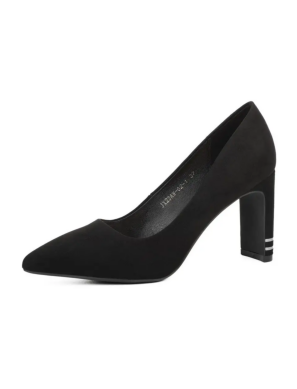

In [34]:
next(preds)

In [35]:
def visualise_predict_beam_search(loader: DataLoader,
                                  model,
                                  tokenizer : Tokenizer,
                                  beam_size : int,
                                  max_length : int = 300) -> None:
    for batch in loader:

        complete_seqs, complete_seqs_scores, uncomplete_seqs, uncomplete_seqs_scores = model.caption_image_beam_search(
                                                                          image_embeds=batch['embed'],
                                                                          beam_size=beam_size,
                                                                          max_length=max_length)
        print('ИСТИННОЕ ОПИСАНИЕ')
        print(tokenizer.decode(batch['description'][0].detach().cpu().numpy()) + '\n')
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - ЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(complete_seqs, complete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. " + tokenizer.decode(caption[i].detach().cpu().numpy()) + '\n')
                num_captions += 1
        print('СГЕНЕРИРОВАННЫЕ ОПИСАНИЯ - НЕЗАКОНЧЕННЫЕ')
        num_captions = 1
        for caption, score in zip(uncomplete_seqs, uncomplete_seqs_scores):
            for i in range(caption.shape[0]):
                print(f"{num_captions}. ", tokenizer.decode(caption[i].detach().cpu().numpy()))
                num_captions += 1
            
        img_path = batch['path'][0]
        img = Image.open(str(img_path)).convert('RGB')
        plt.axis('off')
        plt.imshow(img);
        yield

In [36]:
preds = visualise_predict_beam_search(test_loader, model, tokenizer, beam_size=3, max_length=100)

ИСТИННОЕ ОПИСАНИЕ
чуни теплые и уютные домашние тапочки с мехом внутри и снаружи и на войлочной подошве от бренда foki - это идеальный подарок на любой праздник или без повода для взрослых женщин и мужчин и парней и девушек - подростков . изготовленные из натуральной овчины и войлока , они сохраняют тепло в холодную зиму и дышат в жаркое лето . мягкая овечья шерсть обеспечивает комфорт и надежное сцепление с полом , а широкая носовая часть и закрытая пятка делают тапочки идеальными для широкой стопы . стильные и модные , они подходят для повседневной носки дома или в дачном домике и отлично дополняют уютный домашний образ . утепленные и очень комфортные изделия дарят ноге тепло в холодную зимнюю или осеннюю погоду . удобные тапки станут отличным выбором для всех , кто хочет порадовать своих близких оригинальным , полезным и практичным подарком . разнообразие цветов и размеров позволит выбрать идеальную пару для каждого - от подростков до пожилых людей . вы можете выбрать стильную комна

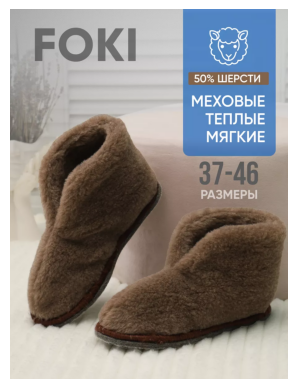

In [40]:
next(preds)

### Мусор по расчету метрик

In [31]:
from torchmetrics.text import WordErrorRate
from sacrebleu import corpus_bleu
from torchtext.data.metrics import bleu_score
from torchmetrics import BLEUScore

In [80]:
preds = ['стикеры для заметок прозрачные 100 штук 9 6 см х 8']
target = ['стикеры для заметок прозрачные 100 штук 9 6 см х 7 см имеют матовую поверхность поэтому на них удобно писать стикеры для книг удобны для подчеркивания и выделения нужных фрагментов текста и зарисовок заполните стикеры закладки важными заданиями рисунками или датами они легко наклеиваются и отклеиваются не оставляют следов это идеальный выбор для организации вашего рабочего пространства']

print(corpus_bleu(preds, [target]))

BLEU = 1.36 90.9/90.0/88.9/87.5 (BP = 0.015 ratio = 0.193 hyp_len = 11 ref_len = 57)


In [29]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the reference", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.5000)
29.84745896009822


In [52]:
preds = ["this is the prediction", "there is another one"]
target = ["this is the reference", "there is another one"]
print(corpus_bleu(preds, [target]).score)

72.31269021297696


In [30]:
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the prediction", "there is another one"]
wer = WordErrorRate()
print(wer(preds, target))
print(corpus_bleu(preds, [target]).score)

tensor(0.3750)
47.47362087808389


In [137]:
preds = [['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]
target = [[['this', 'is', 'the', 'prediction']], [['there', 'is', 'another', 'one']]]

print(bleu_score(preds, target))

0.47473621368408203


In [141]:
preds = ["this is the prediction", "there is an other sample"]
target = [["this is the reference"], ["there is another one"]]


bleu = BLEUScore()
bleu(preds, target)

tensor(0.)

In [114]:
[i.split() for i in preds]

[['this', 'is', 'the', 'prediction'], ['there', 'is', 'an', 'other', 'sample']]

In [111]:
[[i.split()] for i in target]

[[['this', 'is', 'the', 'reference']], [['there', 'is', 'another', 'one']]]

In [120]:
candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']], [['Completely', 'Different']]]
bleu_score(candidate_corpus, references_corpus)

0.8408964276313782

In [34]:
def det_test(a):
    return a

check = True
det_test(a=1 if check else 2)

1